##### RAG - Retrieval-Augmented Generation
13-Dec-2025

Preprocessing documents into a format that can be understood and searched with LLMs

 Extract the text from the document.
1. Split the text into manageable chunks.  ~300 tokens/chunk.
2. Convert the text into numbers that computers can understand - Vector Embeddings.
3. Store these number representations of your text somewhere(vectordb) that makes it easy and fast to retrieve the relevant sections of your document to answer a given question

##### Embedding 
Refers to representing text as a (long) sequence of numbers. This is a lossy representation—that is, you can’t recover the original text from these number sequences, so you usually store both the original text and this numeric representation.

###### BoW - Bag of Word

Bag-of-Words converts text into numbers by counting how many times each word appears. It ignores grammar, order of words, and meaning — it only cares about word frequency

In [2]:
!pip install PyPDF2


  Using cached pypdf2-3.0.1-py3-none-any.whl.metadata (6.8 kB)
Using cached pypdf2-3.0.1-py3-none-any.whl (232 kB)



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import PyPDF2
import re

# -----------------------------
# 1. Extract text from a PDF
# -----------------------------
def extract_pdf_text(pdf_path):
    text = ""
    with open(pdf_path, "rb") as f:
        reader = PyPDF2.PdfReader(f)
        for page in reader.pages:
            text += page.extract_text() + " "
    return text.lower()


# -----------------------------
# 2. Build Bag-of-Words
# -----------------------------
def bag_of_words(text):
    words = re.findall(r"[a-zA-Z]+", text.lower())

    vocabulary = sorted(list(set(words)))
    bow_vector = [words.count(word) for word in vocabulary]

    return vocabulary, bow_vector


# -----------------------------
# Print Vocabulary with Counts
# -----------------------------
def print_vocab_with_counts(vocabulary, bow_vector):
    print("\nWord → Count\n-----------------")
    for word, count in zip(vocabulary, bow_vector):
        print(f"{word:<15} : {count}")  # left aligned for clean formatting


# -----------------------------
# 3. Check if a word exists
# -----------------------------
def word_exists(word, vocabulary, bow_vector):
    if word.lower() in vocabulary:
        index = vocabulary.index(word.lower())
        return bow_vector[index] > 0
    return False


# -----------------------------
# 4. Test the functions
# -----------------------------
pdf_path = "python.pdf"

text = extract_pdf_text(pdf_path)
vocab, bow = bag_of_words(text)

# Print vocabulary next to counts
print_vocab_with_counts(vocab, bow)

print("\nSearch Results:")
search_words = ["python", "pytho", "data", "cloud", "engineering"]

for w in search_words:
    print(f"{w}: {'FOUND' if word_exists(w, vocab, bow) else 'NOT FOUND'}")



Word → Count
-----------------
a               : 1
act             : 1
and             : 1
but             : 1
data            : 1
engineering     : 1
everywhere      : 1
giving          : 1
having          : 1
helps           : 1
humans          : 1
in              : 1
intel           : 1
is              : 4
it              : 1
language        : 1
learning        : 2
libraries       : 1
ligence         : 1
like            : 1
lot             : 1
machine         : 2
machines        : 1
nothing         : 1
of              : 1
popular         : 1
programming     : 1
python          : 2
the             : 1
to              : 2
used            : 1
which           : 1
widely          : 1

Search Results:
python: FOUND
pytho: NOT FOUND
data: FOUND
cloud: NOT FOUND
engineering: FOUND


In [26]:
sentences = [
    "What a sunny day.",
    "Such bright skies today.",
    "I haven’t seen a sunny day in weeks."
]

import re

# Clean & tokenize
tokenized = [
    re.findall(r"[a-zA-Z’]+", s.lower())  # includes apostrophes
    for s in sentences
]

# Build vocabulary
vocab = sorted(set(word for words in tokenized for word in words))

# Create binary BoW matrix
bow_matrix = []
for word in vocab:
    row = []
    for sentence_words in tokenized:
        row.append(1 if word in sentence_words else 0)
    bow_matrix.append((word, row))

# Column widths
col_word = 15
col_s1 = 25
col_s2 = 28
col_s3 = 40

# Print header
print(f"{'Word'.ljust(col_word)} | {'What a sunny day.'.ljust(col_s1)} | {'Such bright skies today.'.ljust(col_s2)} | {'I haven’t seen a sunny day in weeks.'.ljust(col_s3)}")
print("-" * (col_word + col_s1 + col_s2 + col_s3 + 10))

# Print each row
for word, row in bow_matrix:
    print(
        f"{word.ljust(col_word)} | "
        f"{str(row[0]).ljust(col_s1)} | "
        f"{str(row[1]).ljust(col_s2)} | "
        f"{str(row[2]).ljust(col_s3)}"
    )


Word            | What a sunny day.         | Such bright skies today.     | I haven’t seen a sunny day in weeks.    
----------------------------------------------------------------------------------------------------------------------
a               | 1                         | 0                            | 1                                       
bright          | 0                         | 1                            | 0                                       
day             | 1                         | 0                            | 1                                       
haven’t         | 0                         | 0                            | 1                                       
i               | 0                         | 0                            | 1                                       
in              | 0                         | 0                            | 1                                       
seen            | 0                         | 0        

these embeddings are also called sparse embeddings

##### Cosine Similarity

One effective way to calculate the degree of similarity between two vectors in a
multidimensional space is called cosine similarity. 


Cosine similarity computes the dot product of vectors and divides it by the product of their magnitudes to output a number between –1 and 1, where 0 means the vectors share no correlation, –1 means they are absolutely dissimilar, and 1 means they are absolutely similar. 


So, in the case of our three words here, the cosine similarity between pet and dog could be 0.75, but between pet and lion it might be 0.1

In [27]:
!pip install matplotlib

  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-12.0.0-cp313-cp313-win_amd64.whl.metadata (9.0 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------ --------------------------------- 1.3/8.1 MB 7.4 MB/s eta 0:00:01
   --------------- ------------------------ 3.1/8.1 MB 7.7 MB/s eta 0:00:01
   ----------------------- ---------------- 4.7/8.1 MB 7.7 MB/s eta 0:00:01
   ------------------------------ --------- 6.3/8.1 MB 7.6 MB/s eta 0:00:01
   ------------------------------------ --- 7.3/8.1 MB 7.1 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 6.8 MB/s eta 0:00:00
Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl (226 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
 


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


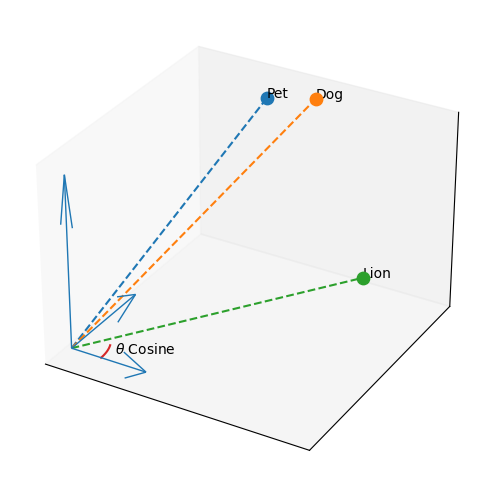

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Create 3D plot
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection='3d')

# Word vectors (example coordinates)
pet = np.array([1, 2, 1])
dog = np.array([1.5, 2.2, 1])
lion = np.array([3, 1, 0.5])

origin = np.zeros(3)

# Plot axes
ax.quiver(0,0,0, 1,0,0, linewidth=1)
ax.quiver(0,0,0, 0,1,0, linewidth=1)
ax.quiver(0,0,0, 0,0,1, linewidth=1)

# Plot dashed lines to points
ax.plot([0,pet[0]], [0,pet[1]], [0,pet[2]], linestyle='dashed')
ax.plot([0,dog[0]], [0,dog[1]], [0,dog[2]], linestyle='dashed')
ax.plot([0,lion[0]], [0,lion[1]], [0,lion[2]], linestyle='dashed')

# Scatter points
ax.scatter(*pet, s=80)
ax.scatter(*dog, s=80)
ax.scatter(*lion, s=80)

# Labels near points
ax.text(*pet, "Pet")
ax.text(*dog, "Dog")
ax.text(*lion, "Lion")

# Approx cosine angle arc (manually drawn 2D-like in 3D)
theta = np.linspace(0, np.pi/6, 30)
arc_x = 0.4 * np.cos(theta)
arc_y = 0.4 * np.sin(theta)
arc_z = np.zeros_like(theta)
ax.plot(arc_x, arc_y, arc_z)

ax.text(0.5, 0.1, 0, r"$\theta$ Cosine")

# Clean background
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_zlabel('')

plt.tight_layout()
plt.show()


Document loaders in langchain

In [30]:
!pip install langchain_community

  Using cached langchain_community-0.4.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached langchain_classic-1.0.0-py3-none-any.whl.metadata (3.9 kB)
  Using cached aiohttp-3.13.2-cp313-cp313-win_amd64.whl.metadata (8.4 kB)
  Using cached dataclasses_json-0.6.7-py3-none-any.whl.metadata (25 kB)
  Using cached pydantic_settings-2.12.0-py3-none-any.whl.metadata (3.4 kB)
  Using cached httpx_sse-0.4.3-py3-none-any.whl.metadata (9.7 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.4.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached attrs-25.4.0-py3-none-any.whl.metadata (10 kB)
  Using cached frozenlist-1.8.0-cp313-cp313-win_amd64.whl.metadata (21 kB)
  Using cached multidict-6.7.0-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached propcache-0.4.1-cp313-cp313-win_amd64.whl.metadata (14 kB)
  Using cached yarl-1.22.0-cp313-cp313-win_amd64.whl.metadata (77 kB)
  Using cached marshmallow-3.26.1-py3-none-any.whl.metadata (7.3 kB)


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
from langchain_community.document_loaders import TextLoader
loader = TextLoader("./langchain.txt")
loader.load()[0].page_content

'LangChain is an open-source framework for building applications powered by large language models (LLMs) by providing tools to connect LLMs with external data and logic. It simplifies development by offering pre-built components and a modular structure that allows developers to create complex applications like chatbots, document analysis tools, and intelligent question-answering systems. The framework is available in Python and JavaScript and helps developers overcome LLM limitations, such as not having access to private data or real-time information, by enabling them to integrate data, memory, and other tools.  \nThis video explains the basic concepts of LangChain and its key components:\nHow LangChain works\nConnects LLMs to data: LangChain allows LLMs to access data from external sources, such as databases or documents, which are often referred to as "indexes". \nProvides a modular framework: It provides a set of tools and abstractions that developers can combine to build applicatio

In [42]:
!pip install beautifulsoup4

  Using cached beautifulsoup4-4.14.3-py3-none-any.whl.metadata (3.8 kB)
  Using cached soupsieve-2.8-py3-none-any.whl.metadata (4.6 kB)
Using cached beautifulsoup4-4.14.3-py3-none-any.whl (107 kB)
Using cached soupsieve-2.8-py3-none-any.whl (36 kB)

   ---------------------------------------- 0/2 [soupsieve]
   ---------------------------------------- 0/2 [soupsieve]
   ---------------------------------------- 0/2 [soupsieve]
   -------------------- ------------------- 1/2 [beautifulsoup4]
   -------------------- ------------------- 1/2 [beautifulsoup4]
   -------------------- ------------------- 1/2 [beautifulsoup4]
   -------------------- ------------------- 1/2 [beautifulsoup4]
   -------------------- ------------------- 1/2 [beautifulsoup4]
   ---------------------------------------- 2/2 [beautifulsoup4]




[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
from langchain_community.document_loaders import WebBaseLoader
loader=WebBaseLoader("https://www.langchain.com/")
loader.load()

[Document(metadata={'source': 'https://www.langchain.com/', 'title': 'LangChain', 'description': 'LangChain provides the engineering platform and open source frameworks developers use to build, test, and deploy reliable AI agents.', 'language': 'en'}, page_content="LangChain\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nProducts\n\nLangSmithObservabilityDebug and monitor in-depth tracesEvaluationIterate on prompts and modelsDeploymentShip and scale agents in productionAgent BuilderBetaBuild no-code agentsOpen Source FrameworksLangChainQuick start agents with any model providerLangGraphBuild custom agents with low-level controlDeep AgentsNewUse planning, memory, and sub-agents for complex, long-running tasksResources\n\nLangChain AcademyBlogCustomer StoriesCommunityEventsChangelogGuidesTrust CenterDocsCompany\n\nAboutCareersPricingTalk to salesSign upEngineer reliable agentsShip agents to production with LangChain's comprehensive platform for agent engineering.Talk to salesSign up\n\nL

In [13]:
loader.load()[0].metadata["description"]

'LangChain provides the engineering platform and open source frameworks developers use to build, test, and deploy reliable AI agents.'

In [7]:
!pip install pypdf


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
from langchain_community.document_loaders import PyPDFLoader
loader = PyPDFLoader("./python.pdf")
pages = loader.load()
pages

[Document(metadata={'producer': 'Microsoft® Word for Microsoft 365', 'creator': 'Microsoft® Word for Microsoft 365', 'creationdate': '2025-12-13T22:56:29+05:30', 'author': 'Yerraballi Suresh Kumar Reddy', 'moddate': '2025-12-13T22:56:29+05:30', 'source': './python.pdf', 'total_pages': 1, 'page': 0, 'page_label': '1'}, page_content='Python is a popular programming language. It is widely used in data engineering and \nmachine learning. Machine Learning is nothing but giving intelligence to the machines \nto act like humans. Python is having lot of libraries which helps everywhere.')]

In [14]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
loader = TextLoader("./langchain.txt") # or any other loader
docs = loader.load()
splitter = RecursiveCharacterTextSplitter(
chunk_size=1000,
chunk_overlap=200,
)
splitted_docs = splitter.split_documents(docs)
splitted_docs

[Document(metadata={'source': './langchain.txt'}, page_content='LangChain is an open-source framework for building applications powered by large language models (LLMs) by providing tools to connect LLMs with external data and logic. It simplifies development by offering pre-built components and a modular structure that allows developers to create complex applications like chatbots, document analysis tools, and intelligent question-answering systems. The framework is available in Python and JavaScript and helps developers overcome LLM limitations, such as not having access to private data or real-time information, by enabling them to integrate data, memory, and other tools.  \nThis video explains the basic concepts of LangChain and its key components:\nHow LangChain works\nConnects LLMs to data: LangChain allows LLMs to access data from external sources, such as databases or documents, which are often referred to as "indexes". \nProvides a modular framework: It provides a set of tools a

In [15]:
from langchain_text_splitters import (
Language,
RecursiveCharacterTextSplitter,
)
PYTHON_CODE = """
def hello_world():
    print("Hello, World!")
# Call the function
hello_world()
"""
python_splitter = RecursiveCharacterTextSplitter.from_language(
language=Language.PYTHON, chunk_size=50, chunk_overlap=0
)
python_docs = python_splitter.create_documents([PYTHON_CODE])
python_docs

[Document(metadata={}, page_content='def hello_world():\n    print("Hello, World!")'),
 Document(metadata={}, page_content='# Call the function\nhello_world()')]

In [2]:
from langchain_aws import ChatBedrockConverse

from langchain_aws import BedrockEmbeddings

In [3]:
bedrock_embeddings = BedrockEmbeddings(model_id="amazon.titan-embed-text-v2:0")
embeddings=bedrock_embeddings.embed_query("This is a content of the document")
embeddings

[-0.07991170138120651,
 0.04650881513953209,
 0.0326104573905468,
 -0.0024422467686235905,
 0.00020711177785415202,
 -0.006493790540844202,
 0.03160705789923668,
 -0.005468844436109066,
 0.03715791180729866,
 0.019671760499477386,
 -0.03429436683654785,
 0.09882254898548126,
 0.0395924411714077,
 -0.022697392851114273,
 -0.028303561732172966,
 0.05894967168569565,
 -0.04317701607942581,
 0.029021376743912697,
 0.03718814253807068,
 0.03854594752192497,
 0.09325947612524033,
 0.03074001893401146,
 -0.021362101659178734,
 0.03130475431680679,
 -0.03813108056783676,
 -0.014243115670979023,
 -0.00856748130172491,
 0.004812454339116812,
 0.02727186121046543,
 -0.014289426617324352,
 0.03871060535311699,
 0.056079696863889694,
 -0.0008451704634353518,
 -0.06615227460861206,
 0.07864587754011154,
 0.11220312863588333,
 0.07026877999305725,
 -0.0036353906616568565,
 -0.014912048354744911,
 -0.015388019382953644,
 0.014102897606790066,
 -0.011090771295130253,
 -0.0032623321749269962,
 0.0292143

In [32]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
loader = TextLoader("./langchain.txt") # or any other loader
docs = loader.load()
splitter = RecursiveCharacterTextSplitter(
chunk_size=1000,
chunk_overlap=200,
)
splitted_docs = splitter.split_documents(docs)
type(splitted_docs)
splitted_docs

[Document(metadata={'source': './langchain.txt'}, page_content='LangChain is an open-source framework for building applications powered by large language models (LLMs) by providing tools to connect LLMs with external data and logic. It simplifies development by offering pre-built components and a modular structure that allows developers to create complex applications like chatbots, document analysis tools, and intelligent question-answering systems. The framework is available in Python and JavaScript and helps developers overcome LLM limitations, such as not having access to private data or real-time information, by enabling them to integrate data, memory, and other tools.  \nThis video explains the basic concepts of LangChain and its key components:\nHow LangChain works\nConnects LLMs to data: LangChain allows LLMs to access data from external sources, such as databases or documents, which are often referred to as "indexes". \nProvides a modular framework: It provides a set of tools a

In [35]:
bedrock_embeddings = BedrockEmbeddings(model_id="amazon.titan-embed-text-v2:0")
for emb in splitted_docs:
    embeddings = bedrock_embeddings.embed_documents([emb.page_content])
    print(embeddings)


[[0.029504479840397835, 0.07072167098522186, 0.03325970098376274, -0.00282760220579803, 0.06538804620504379, 0.008282460272312164, -0.03383428975939751, -0.013252077624201775, -0.01082313060760498, -0.07353740185499191, -0.03150169551372528, 0.0034699426032602787, 0.004407655447721481, 0.043476082384586334, -0.04169526323676109, -0.044321127235889435, 0.028730329126119614, -0.007239186204969883, 0.07083769887685776, 0.02522658370435238, 0.0014964680885896087, -0.00493683060631156, -0.021131016314029694, -0.012806461192667484, -0.03289618343114853, -0.020869290456175804, -0.013408591039478779, 0.00952085293829441, 0.002738980343565345, -0.0001189203976537101, -0.04395442456007004, 0.04630227014422417, 0.04231404513120651, -0.024366969242691994, 0.05011897161602974, 0.057840269058942795, 0.0730399489402771, 0.038471587002277374, 0.018560659140348434, -0.015586226247251034, -0.031524404883384705, 0.0038159226533025503, -0.0012364680878818035, 0.003944019787013531, -0.027035564184188843, -